<a href="https://colab.research.google.com/github/joaodpcm/MDA/blob/preprocessing_data_david/regressor_model_mda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages


In [1]:
# Import libraries
'''!pip install pandas-profiling
!pip install ydata-profiling
!pip install geopy
!pip install autoviz
!pip install matplotlib
!pip install -U textblob
!pip install statsmodels
!pip install missingno
!python -m textblob.download_corpora
!pip install missingpy
!pip install scikit-learn
!pip install sklearn'''
import numpy as np 
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import os
import sklearn

# Clone repository

In [3]:
#Accessing GitHub repository
!git clone <https://github.com/joaodpcm/MDAgit>

/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `git clone <https://github.com/joaodpcm/MDAgit>'


In [2]:
# Set path to the directory containing the meta dataset
path_copy_meteo = "meteo_data/data_final_meteo.csv"
df_meteo = pd.read_csv(path_copy_meteo)
path_copy_noise = "noise_data/events_noise2.xlsx"
df_noise = pd.read_excel(path_copy_noise)

In [3]:
df_noise = df_noise.rename(columns={"startTime": "DATEUTC", "noise_level": "target"})

In [4]:
df_noise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8777 entries, 0 to 8776
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATEUTC    8777 non-null   object 
 1   id         404 non-null    float64
 2   title      404 non-null    object 
 3   endTime    404 non-null    object 
 4   url        399 non-null    object 
 5   tags       383 non-null    object 
 6   address    404 non-null    object 
 7   name       382 non-null    object 
 8   latitude   154 non-null    float64
 9   longitude  154 non-null    float64
 10  city       404 non-null    object 
 11  target     8674 non-null   float64
 12  comp       8674 non-null   object 
 13  event_yes  8777 non-null   int64  
dtypes: float64(4), int64(1), object(9)
memory usage: 960.1+ KB


In [5]:
df = df_meteo.merge(df_noise, how='inner', on='DATEUTC')

In [6]:
df['DATEUTC'] = pd.to_datetime(df['DATEUTC'])

In [7]:
df['nameday'] = df['DATEUTC'].dt.dayofweek

In [8]:
df['hour'] = df['DATEUTC'].dt.hour

In [9]:
df = df.rename(columns={'LC_WINDSPEED': "wind", 'LC_TEMP_QCL3': 'temp','LC_RAININ':'rain','LC_HUMIDITY':'humidity'})

In [10]:
df = df.dropna(subset=['target'])

In [11]:
# Renaming missing values
df = df.replace('', np.NaN)
# Renaming missing values
df = df.replace('', np.NaN)
# Getting the total missing values
print("{} missing values within the dataset.".format(df['target'].isna().sum().sum())) 

0 missing values within the dataset.



# Splitting data


In [12]:
# Extracting correct features
from sklearn.model_selection import train_test_split
x = df[['temp', 'nameday', 'hour', 'humidity', 'rain', 'wind', 'event_yes']]
  
y = df['target']

# # Extracting correct features
# from sklearn.model_selection import train_test_split
# x = df[['LC_TEMP_QCL3', 'LC_HUMIDITY', 'LC_WINDSPEED', 'LC_RAININ',
#        'LC_DAILYRAIN', 'nameday']]
  
# y = df['target']

# Splitting data into train data and validation data 
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

## Random Forest

c:\Users\joaod\anaconda3\envs\MDA\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\joaod\anaconda3\envs\MDA\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\joaod\anaconda3\envs\MDA\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\joaod\anaconda3\envs\MDA\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in vers

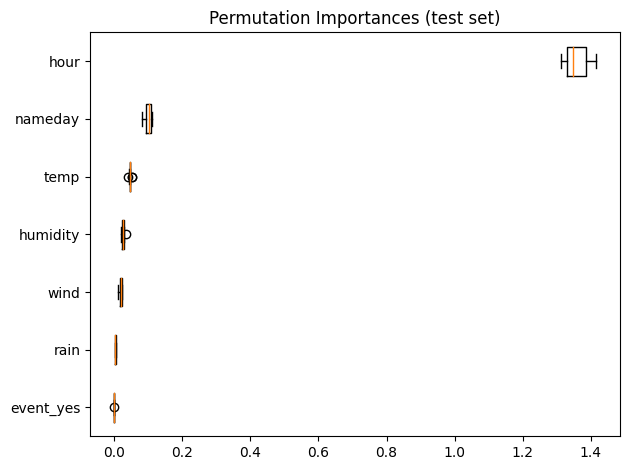

In [13]:
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.exceptions import NotFittedError

# Define numeric and categorical features
numeric_features = ['temp', 'humidity', 'rain', 'wind']
categorical_features = ['hour', 'nameday', 'event_yes']

if 'target' in numeric_features:
    numeric_features.remove('target')

# Define transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Create preprocessor for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=0
)

# Create pipeline with preprocessor and HistGradientBoostingRegressor
hgr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor(max_leaf_nodes=30))
])

# Define groups for LeaveOneGroupOut cross-validation
groups = X_train['hour']  # Assuming 'hour' is used for grouping

# Fit the pipeline on the training data using LeaveOneGroupOut cross-validation
for train_index, test_index in LeaveOneGroupOut().split(X_train, y_train, groups):
    hgr.fit(X_train.iloc[train_index], y_train.iloc[train_index])

# Make predictions on the test data
y_pred_hgr = hgr.predict(X_test)

# Get the permutation importances
try:
    result = permutation_importance(hgr, X_test, y_test, n_repeats=10, random_state=42)
except NotFittedError:
    # Handle the case where the model is not fitted
    result = None

if result is not None:
    sorted_idx = result.importances_mean.argsort()

    # Plot the feature importances
    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    fig.tight_layout()
    plt.show()
else:
    print("Model not fitted.")

# from sklearn.inspection import permutation_importance
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.inspection import permutation_importance
# from sklearn.exceptions import NotFittedError


# # Define numeric and categorical features
# numeric_features = ['temp', 'humidity', 'rain', 'wind']
# categorical_features = ['hour', 'nameday']

# if 'target' in numeric_features:
#     numeric_features.remove('target')
# # Define transformers for numeric and categorical features
# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
# ])

# # Create preprocessor for numeric and categorical features
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ],
#     sparse_threshold=0
# )

# # Create pipeline with preprocessor and HistGradientBoostingRegressor
# hgr = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', HistGradientBoostingRegressor(max_leaf_nodes=30))
# ])

# # Fit the pipeline on the training data
# hgr.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred_hgr = hgr.predict(X_test)

# # Get the permutation importances
# try:
#     result = permutation_importance(hgr, X_test, y_test, n_repeats=10, random_state=42)
# except NotFittedError:
#     # Handle the case where the model is not fitted
#     result = None

# if result is not None:
#     sorted_idx = result.importances_mean.argsort()

#     # Plot the feature importances
#     fig, ax = plt.subplots()
#     ax.boxplot(result.importances[sorted_idx].T,
#                vert=False, labels=X_test.columns[sorted_idx])
#     ax.set_title("Permutation Importances (test set)")
#     fig.tight_layout()
#     plt.show()
# else:
#     print("Model not fitted.")

In [51]:
# Plot for Random Forest

In [14]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_poisson_deviance, mean_squared_log_error

def score_estimator(estimator, X_test, y_test):
    """Score an estimator on the test set."""
    y_pred = np.round(estimator.predict(X_test))

    print(
        "MSE: %.3f"
        % mean_squared_error(
            y_test, y_pred
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            y_test, y_pred
        )
    )

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    print(
        "RMSE: %.3f"
        % np.sqrt(mean_squared_error(
            y_test[mask],
            y_pred[mask]
        ))
    )

In [15]:
print("HGBR evaluation:")
score_estimator(hgr, X_test, y_test)

HGBR evaluation:
MSE: 12.156
MAE: 2.535
RMSE: 3.487


# Trial on realtime data



In [16]:
# df = pd.read_csv("routes.csv")
os.chdir("/content/drive/MyDrive/modern_data_analysis")

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: '/content/drive/MyDrive/modern_data_analysis'

In [17]:
!pip install beautifulsoup4
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
from datetime import timedelta
content = "https://weather.com/weather/hourbyhour/l/c097b546627cdff2da1e276cb9b2731055718a5e7270d777a92857a9701c7870"
response = requests.get(content)
soup = BeautifulSoup(response.content, 'html.parser')

temp_val = soup.findAll('div', attrs={'class':'DetailsTable--field--CPpc_'})


forecast = pd.DataFrame()
forecast['temp'] = [round((int(temp_val[i].text[-3:-1])-32 ) *5/9, 1) for i in list(np.array(range(288))) if i%6 == 0]
forecast['wind'] = [float(temp_val[i].text.split(' ')[1]) for i in list(np.array(range(288))) if i%6 == 1]
forecast['wind_direction'] = [temp_val[i].text.split(' ')[0] for i in list(np.array(range(288))) if i%6 == 1]
forecast['humidity'] = [int(temp_val[i].text[-3:-1]) for i in list(np.array(range(288))) if i%6 == 2]
forecast['cloud_cover'] = [int(temp_val[i].text.replace('Cloud Cover', '')[:-1]) for i in list(np.array(range(288))) if i%6 == 4]
forecast['rain'] = [int(temp_val[i].text.replace('Rain Amount', '').replace(' in', '')) for i in list(np.array(range(288))) if i%6 == 5]
weekday = [(datetime.now()+timedelta(hours=i)).weekday() for i in range(48)]
hour_of_day = [(datetime.now()+timedelta(hours=i)).hour for i in range(48)]
forecast['nameday'] = weekday
forecast['hour'] = hour_of_day
forecast['event_yes'] = '' # This value has to be included by the user. So edit this. The value now is missing, but the model running, so even if nothing is provided, it will run
forecast['tag_category'] = '' # This value has to be included by the user. So edit this


In [18]:
# Generate predictions on the test set
prediction_app = hgr.predict(forecast)

In [19]:
prediction_app

array([58.85165756, 57.55641347, 60.13715829, 55.6747241 , 53.79370177,
       50.37241955, 45.54868808, 47.21671259, 46.42524115, 53.02611512,
       60.26729649, 61.4866527 , 61.40085282, 61.25223007, 60.83389542,
       60.77765394, 60.10550047, 60.07508015, 59.24769333, 58.93210592,
       59.24769333, 60.36214448, 60.16006833, 60.10246247, 59.20943996,
       58.1413039 , 61.49323287, 54.26690199, 52.92065825, 49.40116982,
       46.50763901, 47.0180202 , 46.11468884, 50.86706045, 57.19391483,
       57.5519884 , 58.57251041, 58.68195044, 58.82287866, 58.6001607 ,
       58.10483338, 58.47021074, 57.80182619, 56.94553367, 57.40603779,
       58.64577665, 58.22215046, 58.54796482])

# Saving pre trained model

In [20]:
import pickle

In [ ]:
with open('Regressor_trained_model.pkl', 'wb') as f:
    pickle.dump(hgr, f)